## Step 1: Import Libraries and Mount Google Drive

In [1]:
from google.colab import drive, output
from google.colab.patches import cv2_imshow
import os, time, csv, glob
import cv2
import numpy as np
from base64 import b64decode
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
drive.mount('/content/drive')

Mounted at /content/drive


## Step 2: Dataset Path & Haar Cascade Load

In [2]:
DATASET_DIR = '/content/drive/MyDrive/dataset'
ATTENDANCE_CSV = '/content/drive/MyDrive/attendance_log.csv'
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

## Step 3: Image Preprocessing & Augmentation

In [3]:
IMG_SIZE = (227,227)
def preprocess_bgr(bgr):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, IMG_SIZE)
    return rgb.astype('float32') / 255.0
def augment_basic(img):
    return [img, img[:, ::-1, :], np.clip(img*1.1,0,1), np.clip(img*0.9,0,1)]

## Step 4: Load Student-wise Dataset

In [4]:
X, Y, class_names = [], [], []
folders = sorted(os.listdir(DATASET_DIR))
for idx, folder in enumerate(folders):
    path = os.path.join(DATASET_DIR, folder)
    if not os.path.isdir(path):
        continue
    class_names.append(folder)
    for imgf in glob.glob(path + '/*'):
        img = cv2.imread(imgf)
        if img is None:
            continue
        base = preprocess_bgr(img)
        for a in augment_basic(base):
            X.append(a)
            Y.append(idx)
X = np.array(X)
Y = np.array(Y)

## Step 5: Normalize Data & Encode Labels

In [5]:
mean_img = np.mean(X, axis=0)
X = X - mean_img
Y = to_categorical(Y, num_classes=len(class_names))

## Step 6: AlexNet Model Architecture

In [6]:
model = Sequential([
 layers.Input(shape=(227,227,3)),
 layers.Conv2D(96,(11,11),strides=(4,4),activation='relu'),
 layers.MaxPooling2D((2,2)),
 layers.BatchNormalization(),
 layers.Conv2D(256,(11,11),activation='relu'),
 layers.MaxPooling2D((2,2)),
 layers.BatchNormalization(),
 layers.Conv2D(384,(3,3),activation='relu'),
 layers.BatchNormalization(),
 layers.Conv2D(384,(3,3),activation='relu'),
 layers.BatchNormalization(),
 layers.Conv2D(256,(3,3),activation='relu'),
 layers.MaxPooling2D((2,2)),
 layers.Flatten(),
 layers.Dense(4096, activation='relu'),
 layers.Dropout(0.5),
 layers.Dense(4096, activation='relu'),
 layers.Dropout(0.5),
 layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27, 27, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 17, 256)    │     2,973,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,953,154 (91.37 MB)

 Trainable params: 23,950,914 (91.37 MB)

 Non-trainable params: 2,240 (8.75 KB)

## Step 7: Train AlexNet Model

In [7]:
model.fit(X, Y, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8250 - loss: 0.3965
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 2.2660e-05
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 4.7684e-08
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00


## Step 8: Attendance Logging Function

In [8]:
def mark_attendance(name):
    now = datetime.now()
    exists = os.path.exists(ATTENDANCE_CSV)
    with open(ATTENDANCE_CSV,'a',newline='') as f:
        w = csv.writer(f)
        if not exists:
            w.writerow(['date','time','name'])
        w.writerow([now.date(), now.time(), name])

## Step 9: Webcam Capture (Colab)

In [9]:
def js_capture():
    js = """
    async function capture(){
      const video=document.createElement('video');
      const stream=await navigator.mediaDevices.getUserMedia({video:true});
      video.srcObject=stream; await video.play();
      const canvas=document.createElement('canvas');
      canvas.width=640; canvas.height=480;
      canvas.getContext('2d').drawImage(video,0,0);
      stream.getTracks().forEach(t=>t.stop());
      return canvas.toDataURL('image/png');}
    capture();"""
    data = output.eval_js(js)
    return np.frombuffer(b64decode(data.split(',')[1]), np.uint8)

## Step 10: Face Detection, Recognition & Attendance

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


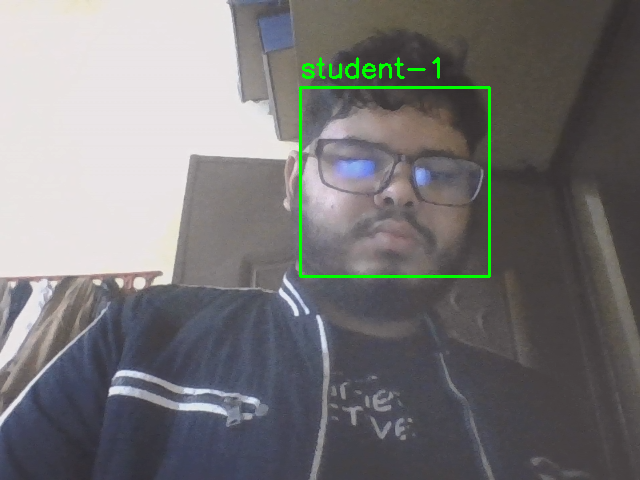

In [13]:
buf = js_capture()
frame = cv2.imdecode(buf, 1)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray,1.1,4)
for (x,y,w,h) in faces:
    face = frame[y:y+h, x:x+w]
    x1 = preprocess_bgr(face) - mean_img
    pred = model.predict(np.expand_dims(x1,0))
    idx = np.argmax(pred)
    name = class_names[idx]
    mark_attendance(name)
    cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.putText(frame,name,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.9,(0,255,0),2)
cv2_imshow(frame)